In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from financepy.utils import *
from financepy.products.rates import *
from financepy.utils.day_count import DayCount, DayCountTypes
import financepy.products.rates.ibor_curve_risk_engine as re
from financepy.market.curves import *
import pickle
from datetime import timedelta
from scipy.optimize import minimize
%matplotlib widget
%matplotlib auto

####################################################################
# FINANCEPY BETA Version 0.230 - This build:  03 Mar 2024 at 16:11 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################

Using matplotlib backend: module://ipympl.backend_nbagg


In [2]:
# open the pickel file curves.pkl and df_yield.pkl
with open('curves.pkl', 'rb') as f:
    curves = pickle.load(f)
with open('df_yield.pkl', 'rb') as f:
    df_yield = pickle.load(f)
df_yield = df_yield.astype(np.float32)

In [3]:
# convert outwright yield to change in yield
df_changes = df_yield.diff()
df_changes.dropna(inplace=True)
df_changes.head()

,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50
Date,,,,,,,,,,,,,,,,,
2022-01-28,0.000264,0.000325,0.000290,0.000262,0.000226,0.000269,0.000226,0.000224,0.000221,0.000232,0.000279,0.000239,0.000273,0.000305,0.000346,0.000314,0.000315
2022-01-31,0.000435,0.000666,0.000699,0.000575,0.000479,0.000454,0.000460,0.000492,0.000459,0.000467,0.000537,0.000473,0.000502,0.000498,0.000512,0.000570,0.000602
2022-02-01,-0.000078,-0.000121,-0.000069,-0.000034,-0.000012,-0.000030,-0.000034,-0.000075,-0.000039,-0.000040,-0.000092,-0.000081,-0.000110,-0.000103,-0.000110,-0.000149,-0.000132
2022-02-02,-0.000130,-0.000208,-0.000260,-0.000231,-0.000213,-0.000220,-0.000236,-0.000250,-0.000260,-0.000270,-0.000288,-0.000309,-0.000370,-0.000410,-0.000450,-0.000460,-0.000495
2022-02-03,0.001779,0.001530,0.001245,0.001119,0.001068,0.001030,0.001008,0.001033,0.001041,0.000977,0.000944,0.000874,0.000835,0.000809,0.000787,0.000721,0.000673


## PCA
- use first 6m of yield curve for PCA
- we restrict to only first 20 years since we don't care the very long end of the curve

Proportion of variance explained by first 3: [0.94649953 0.04516112 0.005589  ]


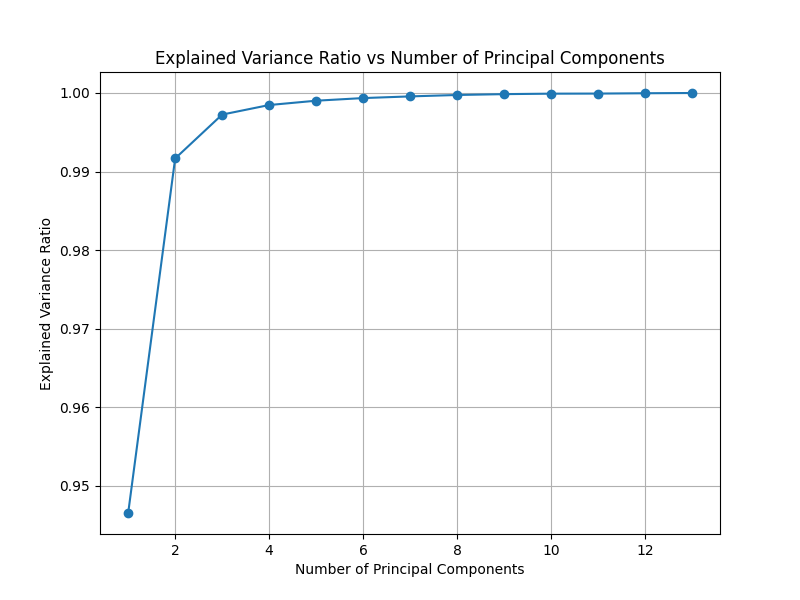

In [4]:
# PCA on first 20 years
df_PCA =  df_changes.loc[:, df_changes.columns <= 20] # only select first 20 years for PCA

df_scale = (df_PCA - df_PCA.mean(axis = 0)) / df_PCA.std(axis = 0) # standardize the data
first_date = df_scale.index[0] # first_date is a string
six_months = timedelta(days=30 * 6) # 6 months in days
end_date = first_date + six_months # Add 6 months to the original datetime
# convert end_date back to 'dd-mm-yyyy'
dates =  df_PCA.index
mask = (dates >= first_date) & (dates <= end_date) # mask for first 6 months
df_scale = df_scale[mask] # only use first 6 months of data

# conduct PCA
cov_matrix = np.cov(df_scale.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
explained_variance = eigenvalues / sum(eigenvalues)
explained_variance_ratio = explained_variance.cumsum()

# store the principle components
PC1 = df_scale.dot(eigenvectors[:,0]) # if X=U*Sigma*V^T, then PC1 = X*V[:,0] = U[:,0]*Sigma[0,0]
PC2 = df_scale.dot(eigenvectors[:,1])
PC3 = df_scale.dot(eigenvectors[:,2])

# plot explained variance ratio
print('Proportion of variance explained by first 3:',explained_variance[:3])
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Principal Components')
plt.grid()

the correlation between 1st PC and 10Y yield changes is: 0.9851177614609417


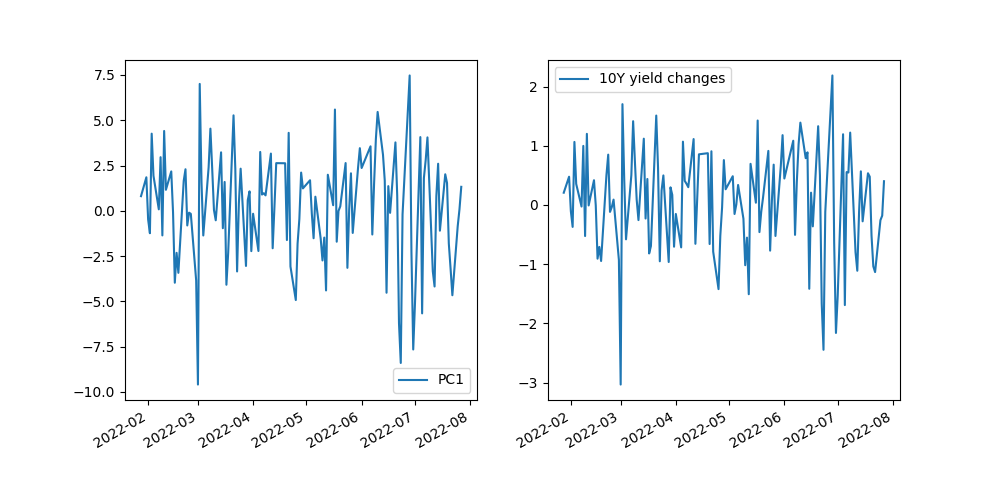

In [5]:
# get the corrlation between 1st PC and level using 10Y
print(f"the correlation between 1st PC and 10Y yield changes is: {np.corrcoef(-PC1, df_scale.loc[:,10])[0][1]}")
# 1nd PC is the level of the curve
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(dates[mask], -PC1, label='PC1')
plt.legend()
plt.subplot(1,2,2)
plt.plot(dates[mask], df_scale.loc[:,10], label='10Y yield changes')
# make the x-axis date less
plt.gcf().autofmt_xdate()
plt.legend()

the correlation between 2nd PC and 2s5s10s butterfly is: -0.1245888768767009
the correlation between 2nd PC and 5s10s20s butterfly is: -0.588231425852459
the correlation between 2nd PC and 5s10s spread is: -0.9260108199438588
the correlation between 2nd PC and 2s10s spread is: -0.9773497613018604


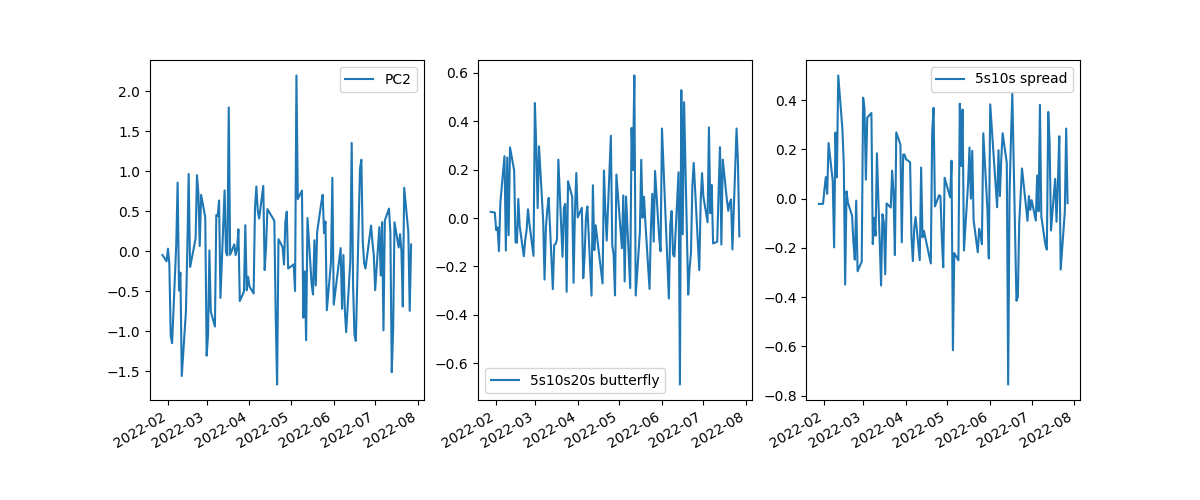

In [6]:
# 2nd PC and its correlation with curvature, slope
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(dates[mask],PC2, label='PC2')
plt.legend()
# calculate the curvature of curve changes
curvature1 = df_scale.loc[:,2] - 2*df_scale.loc[:,5] + df_scale.loc[:,10] # 2s5s10s butterfly
curvature2 = df_scale.loc[:,5] - 2*df_scale.loc[:,10] + df_scale.loc[:,20] # 5s10s20s butterfly
spread_5_10 = df_scale.loc[:,5] - df_scale.loc[:,10] # 5s10s spread
spread_2_10 = df_scale.loc[:,2] - df_scale.loc[:,10] # 2s10s spread
print(f"the correlation between 2nd PC and 2s5s10s butterfly is: {np.corrcoef(PC2, curvature1)[0][1]}")
print(f"the correlation between 2nd PC and 5s10s20s butterfly is: {np.corrcoef(PC2, curvature2)[0][1]}")
print(f"the correlation between 2nd PC and 5s10s spread is: {np.corrcoef(PC2, spread_5_10)[0][1]}")
print(f"the correlation between 2nd PC and 2s10s spread is: {np.corrcoef(PC2, spread_2_10)[0][1]}")
plt.subplot(1,3,2)
plt.plot(dates[mask],curvature2, label='5s10s20s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()
plt.subplot(1,3,3)
plt.plot(dates[mask],spread_5_10, label='5s10s spread')
plt.gcf().autofmt_xdate()
plt.legend()



the correlation between 3rd PC and 2s5s10s butterfly is: 0.6636554192234996
the correlation between 3rd PC and 5s10s20s butterfly is: -0.11335516529013763
the correlation between 3rd PC and 5-10 spread is: -0.3049889877387148
the correlation between 3rd PC and 2-10 spread is: -0.06533911927905965


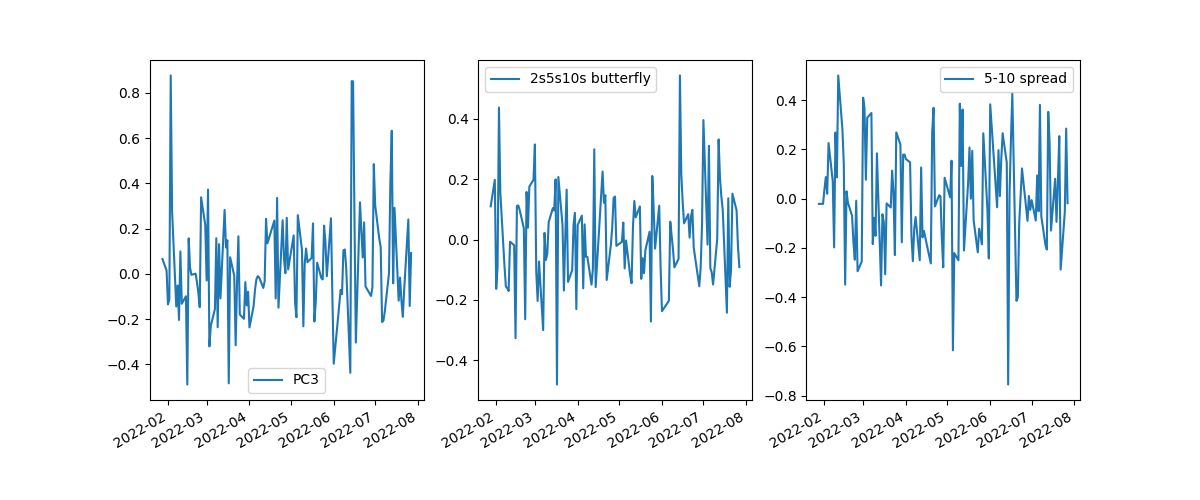

In [7]:
# 3rd PC and its correlation with 2s5s10s butterfly, 5-10 spread
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(dates[mask],PC3, label='PC3')
plt.legend()
print(f"the correlation between 3rd PC and 2s5s10s butterfly is: {np.corrcoef(PC3, curvature1)[0][1]}")
print(f"the correlation between 3rd PC and 5s10s20s butterfly is: {np.corrcoef(PC3, curvature2)[0][1]}")
print(f"the correlation between 3rd PC and 5-10 spread is: {np.corrcoef(PC3, spread_5_10)[0][1]}")
print(f"the correlation between 3rd PC and 2-10 spread is: {np.corrcoef(PC3, spread_2_10)[0][1]}")
plt.subplot(1,3,2)
plt.plot(dates[mask],curvature1, label='2s5s10s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()
plt.subplot(1,3,3)
plt.plot(dates[mask],spread_5_10, label='5-10 spread')
plt.gcf().autofmt_xdate()
plt.legend()



We observe a resonable correlation between 5s10s20s spread and PC2, and we see that 5s10s20s spread is not strongly correlated with PC3. So we have strong evidence that in the first 6m, curvature especially among 5s10s20s section is driving PC2, along with slope. 

## Construct Butterfly Trade

In [8]:
# some parameters
trade_date =  df_yield.index[df_yield.index>end_date][0] # trade from first available date after 6m
day, month, year = trade_date.day, trade_date.month, trade_date.year
valuation_date = Date(day, month, year)
spot_days = 0
settlement_date = valuation_date.add_weekdays(spot_days)
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed
cal = CalendarTypes.UNITED_KINGDOM # calendar type
curve = curves[trade_date] # curve for trade date

In [9]:
# create the 5y, 10y, 20y swaps and for solving the linear system
swap5y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='5Y',
                            fixed_leg_type=SwapTypes.RECEIVE, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

swap10y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='10Y',
                            fixed_leg_type=SwapTypes.PAY, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)
swap20y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='20Y',
                            fixed_leg_type=SwapTypes.RECEIVE, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

# solve the linear system so that the trade is immune to level and slope
pv01_5y = swap5y.pv01(valuation_date, curve)
pv01_10y = swap10y.pv01(valuation_date, curve)
pv01_20y = swap20y.pv01(valuation_date, curve)

### Solve the ratio for notional
We can solve the ratio by either
- Constraint Optimization: maximize the third exposure while constraining first two to be zero.
- Solving the linear system for first two PC2s

We will demonstrate below:

Let $ l_1, l_2, $ and $ l_3 $ be the first three eigenvectors (or loadings) for principal components PC1, PC2, and PC3, respectively. Then let $li[jy]$ be the value of the $i$ th eigenvector for $j$ year, e.g. $l1[10y]$ is the value corresponding to the 10 year tenor for the first eigenvector. We denote the weights of these swaps as $w_{5y}, w_{10y}$, and $w_{20y}$, fixing the body weight $w_{10y} = 1$.

#### Mathematical Formulation:
We need to ensure the portfolio's sensitivity to PC1 and PC2 is neutralized, and portfolio's sensitivity is maximised along PC3. Therefore, we have the following constraint optimization problem:
$$
\text{Maximize}_{\{w_{5y},w_{20y}\}} \{\quad w_{5y} \cdot l3[5y] \cdot PV01_{5y} + w_{10y} \cdot l3[10y] \cdot PV01_{10y} + w_{20y} \cdot l3[20y] \cdot PV01_{20y}\}
$$
While satisfying the two constraits below:
1. **Neutralize Exposure to PC1**:
   $$
   w_{5y} \cdot l1[5y] \cdot PV01_{5y} + 1 \cdot l1[10y] \cdot PV01_{10y} + w_{20y} \cdot l1[20y] \cdot PV01_{20y} = 0
   $$
2. **Neutralize Exposure to PC2**:
   $$
   w_{5y} \cdot l2[5y] \cdot PV01_{5y} + 1 \cdot l2[10y] \cdot PV01_{10y} + w_{20y} \cdot l2[20y] \cdot PV01_{20y} = 0
   $$
We can solve the above constrait optimization through SLSQP in the `scipy` library. Alternatively, we could just solve the linear system for the two constraits. If the trade is orthogonal to both PC1 and PC2, then it should by construction maximally exposed to PC3. This allow us to construct the linear system below:


### Express in Matrix Form:

We define $A$ as the coefficient matrix, $\mathbf{w}$ as the vector of unknowns (weights), and $\mathbf{b}$ as the vector of constants (results of the system). The linear system can be expressed as:

$$
A \mathbf{w} = \mathbf{b}
$$

where

$$
A = \begin{bmatrix}
l1[5y] \cdot PV01_{5y} & l1[20y] \cdot PV01_{20y} \\
l2[5y] \cdot PV01_{5y} & l2[20y] \cdot PV01_{20y}
\end{bmatrix}, \quad
\mathbf{w} = \begin{bmatrix}
w_{5y} \\
w_{20y}
\end{bmatrix}, \quad
\mathbf{b} = \begin{bmatrix}
- l1[10y] \cdot PV01_{10y} \\
- l2[10y] \cdot PV01_{10y}
\end{bmatrix}
$$
the matrix equation can be solved by:
$$
\mathbf{w} = A^{-1} \mathbf{b}
$$
assuming that  $A$ is invertible. If $A$ is singular (not invertible) then we need to use other techniques such as pseudoinverse.

In [10]:
# Solve the ratio for notional using linear system
# Assume eigenvectors are correctly ordered (if not, you need to sort them by eigenvalues)
l1 = eigenvectors[:, 0]  # Loadings on PC1, first column of eigenvectors matrix V, p by 1 vector
l2 = eigenvectors[:, 1]  # Loadings on PC2, orthogonal to PC1 and PC3
l3 = eigenvectors[:, 2]  # Loadings on PC3
PV01s = np.array([pv01_5y, pv01_10y, pv01_20y])
# set up the linear system, loadings
idx_5y, idx_10y, idx_20y = 4, 9, len(df_PCA.columns)-1  # For example purposes
index_list = [idx_5y, idx_10y, idx_20y]

loadings1 = l1[[index_list]][0] # the 1st eigenvector for 5y, 10y, 20y
loadings2 = l2[[index_list]][0] # the 2nd eigenvector for 5y, 10y, 20y
loadings3 = l3[[index_list]][0] # the 3rd eigenvector for 5y, 10y, 20y

# Setting up the system of equations:
# w_5y * (l1[0] * PV01s[0]) + 1 * (l1[1] * PV01s[1]) + w_20y * (l1[2] * PV01s[2]) = 0
# w_5y * (l2[0] * PV01s[0]) + 1 * (l2[1] * PV01s[1]) + w_20y * (l2[2] * PV01s[2]) = 0
A = np.array([
    [loadings1[0] * PV01s[0], loadings1[2] * PV01s[2]],
    [loadings2[0] * PV01s[0], loadings2[2] * PV01s[2]]
])
b = np.array([
    -loadings1[1] * PV01s[1],
    -loadings2[1] * PV01s[1]
])

# Solve the system of linear equations
weights, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None) # rcond=None to avoid warning, s is singular values
w_5y, w_20y = -weights
ratio = [w_5y, w_20y]

print("Solve through linear system")
print("Weight for 5-year swap:", ratio[0])
print("Weight for 20-year swap:", ratio[1])
print(f"So the ratio of the notional for the butterfly trade is: {round(ratio[0],3)}:1:{round(ratio[1],3)}")

Solve through linear system
Weight for 5-year swap: 0.6520341559665941
Weight for 20-year swap: 0.39615869448941265
So the ratio of the notional for the butterfly trade is: 0.652:1:0.396


In [11]:
# solve the ratio for notional using constrained optimization
# Assume eigenvectors and PV01 values are loaded or defined here


# Define the objective function (negative for maximization)
def objective(weights):
    w_5y, w_20y = weights
    return -(w_5y * l3[idx_5y] * PV01s[0] + 1 * l3[idx_10y] * PV01s[1] + w_20y * l3[idx_20y] * PV01s[2])

# Constraints
def constraint1(weights):
    w_5y, w_20y = weights
    return w_5y * l1[idx_5y] * PV01s[0] + 1 * l1[idx_10y] * PV01s[1] + w_20y * l1[idx_20y] * PV01s[2]

def constraint2(weights):
    w_5y, w_20y = weights
    return w_5y * l2[idx_5y] * PV01s[0] + 1 * l2[idx_10y] * PV01s[1] + w_20y * l2[idx_20y] * PV01s[2]

# Initial guesses for weights
initial_guess = [0, 0]

# Define the constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint1},
               {'type': 'eq', 'fun': constraint2}]

# Perform the optimization
result = minimize(objective, initial_guess, constraints=constraints, method='SLSQP')

ratio = -result.x # invert the sign
print("Solve through constrained optimization")
print("Weight for 5-year swap:", ratio[0])
print("Weight for 20-year swap:", ratio[1])
print(f"So the ratio of the notional for the butterfly trade is: {round(ratio[0],3)}:1:{round(ratio[1],3)}")

Solve through constrained optimization
Weight for 5-year swap: 0.652034148852917
Weight for 20-year swap: 0.3961586944743659
So the ratio of the notional for the butterfly trade is: 0.652:1:0.396


In [12]:
# now create the 5y, 10y, 20y swaps for the butterfly trade with correct notionals
swap5y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='5Y',
                            fixed_leg_type=SwapTypes.RECEIVE, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType, notional=round(ratio[0]*10000),
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

swap10y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='10Y',
                            fixed_leg_type=SwapTypes.PAY, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType, notional=10000,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)
swap20y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='20Y',
                            fixed_leg_type=SwapTypes.RECEIVE, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType, notional=round(ratio[1]*10000),
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

# set the trade to be ATM at start
swap5y.set_fixed_rate_to_atm(settlement_date,curve)
swap10y.set_fixed_rate_to_atm(settlement_date,curve)
swap20y.set_fixed_rate_to_atm(settlement_date,curve)

# store their first fixing rate as the par rate since they are ATM
ffr_5y = swap5y.get_fixed_rate()
ffr_10y = swap10y.get_fixed_rate()
ffr_20y = swap20y.get_fixed_rate()

fly_spot_5_10_20 = {
    'spot5y': swap5y,
    'spot10y': swap10y,
    'spot20y': swap20y
}

# some facts about the swaps
print("swap rate")
print(swap5y.swap_rate(valuation_date=valuation_date, discount_curve=curve))
print(swap10y.swap_rate(valuation_date=valuation_date, discount_curve=curve))
print(swap20y.swap_rate(valuation_date=valuation_date, discount_curve=curve))
# print value
print("value")
print(swap5y.value(valuation_date, curve))
print(swap10y.value(valuation_date, curve))
print(swap20y.value(valuation_date, curve))
# print pv01
print("pv01")
print(swap5y.pv01(valuation_date, curve))
print(swap10y.pv01(valuation_date, curve))
print(swap20y.pv01(valuation_date, curve))

swap rate
0.022195000648507966
0.020620999338049232
0.02090199947751784
value
-1.1368683772161603e-13
-4.547473508864641e-13
-2.2737367544323206e-13
pv01
4.671251088470857
8.9168856519724
16.202301226539102


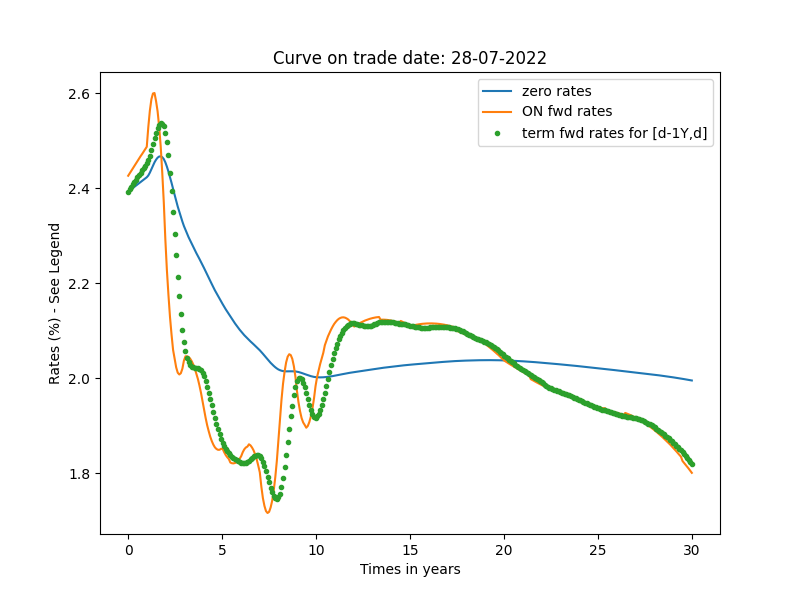

In [13]:
# plot the curve on the day we put on trade
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years shown in the plot
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

plotCurve(curve, settlement_date, 30, instr_mat_dates_or_tenor = '1Y', title = f'Curve on trade date: {trade_date.strftime("%d-%m-%Y")}')

### Carry and Rolldown

In [14]:
trade_to_use = fly_spot_5_10_20
rolldown_tenor = '1Y' # rolldown tenor for carry and rolldown report
last_date = fly_spot_5_10_20['spot20y']._maturity_date # last day of the tenor
risk_res = re.carry_rolldown_report( # carry and rolldown report
    curve, grid_last_date = last_date, grid_bucket_tenor = rolldown_tenor, 
    trades = trade_to_use.values(), trade_labels=list(trade_to_use.keys()), )
df_roll = risk_res[1]

In [15]:
df_roll.head()

,type,start_date,maturity_date,bucket_label,market_rate,DV01:spot5y,DV01:spot10y,DV01:spot20y,DV01:total,ROLL:spot5y,ROLL:spot10y,ROLL:spot20y,ROLL:total
0,IborFRA,28-JUL-2022,01-AUG-2023,0Yx1Y,0.024879,-0.658957,1.010687,-0.400433,-0.048703,-17.030456,41.478359,-15.347422,9.100481
1,IborFRA,01-AUG-2023,01-AUG-2024,1Yx1Y,0.025455,-0.639460,0.982322,-0.389086,-0.046224,3.682809,-5.657434,2.240842,0.266217
2,IborFRA,01-AUG-2024,01-AUG-2025,2Yx1Y,0.020942,-0.623822,0.959843,-0.380073,-0.044052,-28.154852,43.320455,-17.153791,-1.988188
3,IborFRA,01-AUG-2025,01-AUG-2026,3Yx1Y,0.020348,-0.610377,0.940685,-0.372379,-0.042072,-3.621976,5.582022,-2.209698,-0.249653
4,IborFRA,01-AUG-2026,01-AUG-2027,4Yx1Y,0.018921,-0.589160,0.921858,-0.364818,-0.032121,-8.408502,13.156767,-5.206694,-0.458429


DV01:spot5y    -3.121777
DV01:spot10y    9.143776
DV01:spot20y   -6.559207
DV01:total     -0.537208
dtype: float64
ROLL:spot5y    -53.532977
ROLL:spot10y    93.532516
ROLL:spot20y   -31.437531
ROLL:total       8.562008
dtype: float64


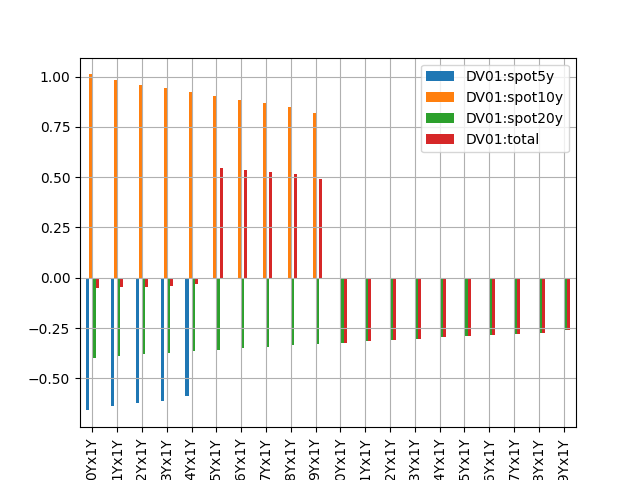

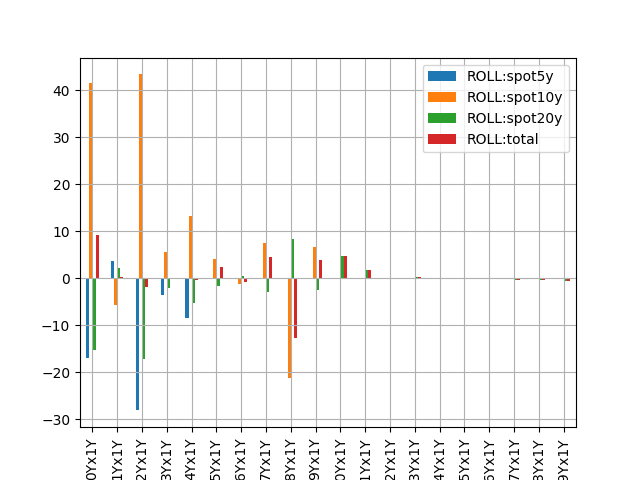

In [16]:
def plot_metric_for_strategy(curve, strategy, metric = 'DV01'):
    """
    plot metric for a strategy
    Inputs:
    curve: IborSingleCurve
    strategy: dict of IborSwap
    metric: str
    """
    rolldown_tenor = '1Y' # rolldown tenor for carry and rolldown report
    last_date = curve._usedSwaps[-1]._maturity_date
    risk_res = re.carry_rolldown_report(
    curve, grid_last_date = last_date, grid_bucket_tenor = rolldown_tenor, 
    trades = strategy.values(), trade_labels=list(strategy.keys()), )
    df_roll = risk_res[1]

    metric_cols = [c for c in df_roll.columns if c.startswith(metric)]
    nonzero_metric = (df_roll[metric_cols] != 0).any(axis = 1) # the rows where the metric is not zero for any of the columns
    df_metric = df_roll.loc[nonzero_metric] # only select the rows where the metric is not zero
    df_metric.plot.bar('bucket_label', metric_cols) # plot the metric
    plt.grid()
    print(df_metric[metric_cols].sum()) # sum of the non-zero metric

#Test (with somewhat convoluted way to just get first 3 outrights)
plot_metric_for_strategy(curve, fly_spot_5_10_20, metric='DV01')
plot_metric_for_strategy(curve, fly_spot_5_10_20, metric='ROLL')

## PNL calculation
- need to valuate a swap given a curve, e.g. `swap5y.value(valuation_date = valuation_date, discount_curve = curve, firstFixingRate = ffr)`
- For IborSwap, the floating leg payments are determined based on the IBOR rates fixed at the start of each interest period. We need to adjust our valuation for the floating leg after each payment date by resetting the firstfixingrate based on the LiborCurve on the payment date. For example, given a 2y swap with annual payment frequency, after the first payment, we reset the firstFixingRate as the 1y Libor rate based on the curve on the payment date.

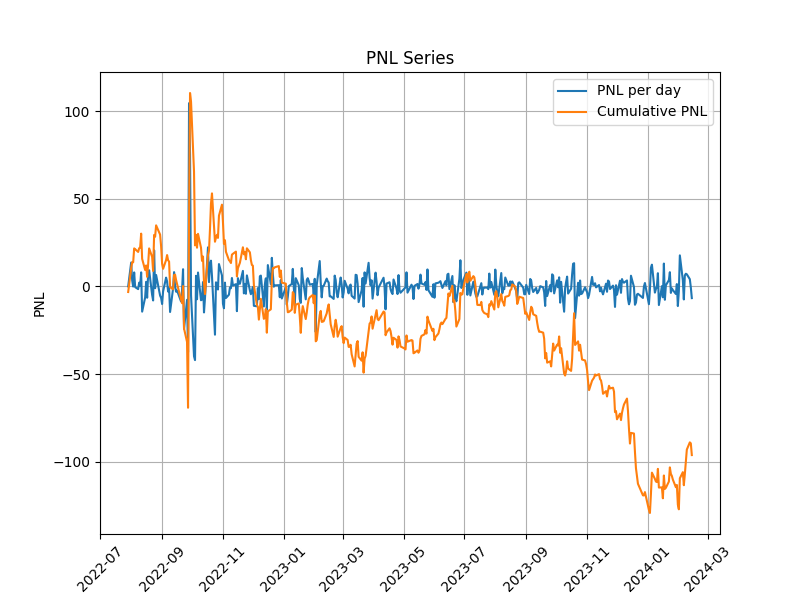

In [17]:
# calculate PNL series (probably need to change the way we calculate pnl)
# the trade date is the first date after 6m
trade_date =  df_yield.index[df_yield.index>end_date][0] # trade from first available date after 6m
day, month, year = trade_date.day, trade_date.month, trade_date.year
valuation_date = Date(day, month, year) # the initial date we want to value
spot_days = 0
settlement_date = valuation_date.add_weekdays(spot_days)
# store an array of payment dates for the trade for PnL adjustment
# since we will only cross 1 payment date, we only need first payment date
payment_dates = swap5y._float_leg._cashflow_report_from_cached_values().payment_date.values # an array of payment dates
first_payment_date = payment_dates[0] # the first payment date
post_trade_dates = df_yield.index[df_yield.index > trade_date] # dates after trade date
curve = curves[trade_date] # initialie curve
# initialize a pd series with 0 pnl for each date
trade_to_use = fly_spot_5_10_20
pnl_series = pd.Series(np.zeros(len(post_trade_dates)),index=post_trade_dates) # pnl per day
cumulative_pnl_series = pd.Series(np.zeros(len(post_trade_dates)),index=post_trade_dates) # cumulative pnl per day

# PNL calculation
for i, date in enumerate(post_trade_dates):
    day, month, year = date.day, date.month, date.year
    new_valuation_date = Date(day, month, year)
    current_curve = curves[date] # the curve on the date
    
    if new_valuation_date >= first_payment_date:
        payment_date = pd.Timestamp(first_payment_date.datetime()) # the first payment date in datetime format
        payment_date_curve = curves[payment_date] # the curve on the payment date
        ffr = payment_date_curve.swap_rate(effective_date=first_payment_date,maturity_date=first_payment_date.add_years(1))
        for swap in trade_to_use.values():
            cumulative_pnl_series[date] += swap.value(valuation_date = new_valuation_date, discount_curve=current_curve, firstFixingRate=ffr)
            if i != 0:
                pnl_series[i] = cumulative_pnl_series[i] - cumulative_pnl_series[i-1]
    else: # if the date is before first payment date, we just set ffr as par rate for each swap
        for swap in trade_to_use.values():
            # need to know which swap this is so i can put ffr, only for 2y, 5y, 10y
            if swap._maturity_date == swap5y._maturity_date:
                ffr = ffr_5y
            elif swap._maturity_date == swap10y._maturity_date:
                ffr = ffr_10y
            else:
                ffr = ffr_20y
            cumulative_pnl_series[date] += swap.value(valuation_date = new_valuation_date, discount_curve=current_curve, firstFixingRate=ffr)
            if i != 0:
                pnl_series[i] = cumulative_pnl_series[i] - cumulative_pnl_series[i-1]

plt.figure(figsize=(8,6))
plt.plot(pnl_series,label = 'PNL per day')
plt.plot(cumulative_pnl_series, label = 'Cumulative PNL')
plt.title('PNL Series')
plt.xlabel('Date')
plt.ylabel('PNL')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

In [18]:
# correlation between pnl and level
print(f"correlation between pnl and 10y yield: {np.corrcoef(pnl_series, df_yield.loc[post_trade_dates,10])[0][1]}")
# correlation between pnl and slope
spread_5_10 = df_changes[10] - df_changes[5] # 10y yield - 5y yield
spread_2_10 = df_changes[10] - df_changes[2] # 10y yield - 2y yield
post_trade_spread = spread_5_10[post_trade_dates] # 5-10 spread post trade
post_trade_spread2 = spread_2_10[post_trade_dates] # 2-10 spread post trade
print(f"correlation between pnl and 5-10 spread: {np.corrcoef(pnl_series, post_trade_spread)[0][1]}")
print(f"correlation between pnl and 2-10 spread: {np.corrcoef(pnl_series, post_trade_spread2)[0][1]}")
# correlation between pnl and curvature
spread_butterfly = -ratio[0]*df_changes[5] + 1*df_changes[10] - ratio[1] * df_changes[20] # 5s10s20s butterfly, with notional 0.832 for 10y as we made it DV01 neutral
post_trade_butterfly = spread_butterfly[post_trade_dates]
print(f"correlation between pnl and 5s10s20s spread: {np.corrcoef(pnl_series, post_trade_butterfly)[0][1]}")

correlation between pnl and 10y yield: 0.015989069787163263
correlation between pnl and 5-10 spread: 0.1771476633558848
correlation between pnl and 2-10 spread: 0.23826961814001418
correlation between pnl and 5s10s20s spread: 0.5398765711746486


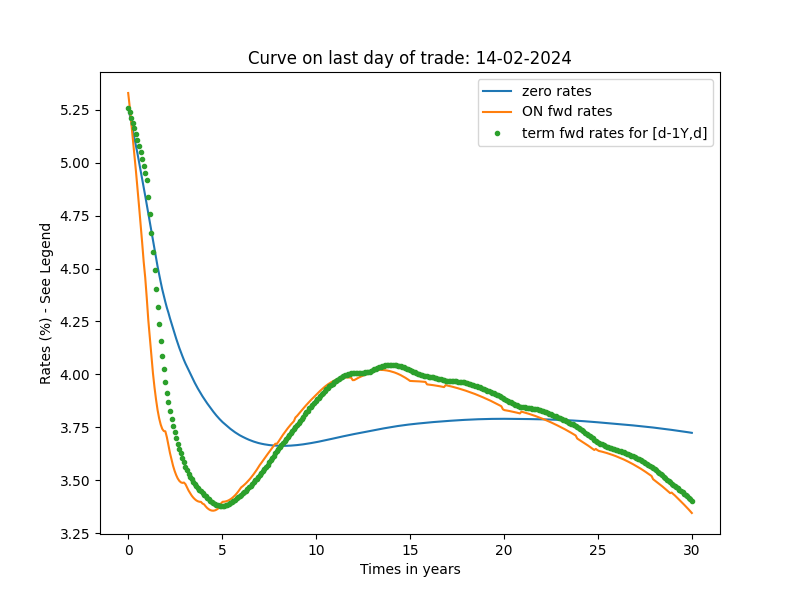

In [19]:
# plot the curve on the last day of the trade to see why pnl oscillates
last_date = df_yield.index[-1]
last_curve = curves[last_date]
day, month, year = last_date.day, last_date.month, last_date.year
last_date_ = Date(day, month, year)
plotCurve(last_curve, last_date_, 30, instr_mat_dates_or_tenor = '1Y', title = f'Curve on last day of trade: {last_date.strftime("%d-%m-%Y")}')

By straight inspection, the reason why our PnL increase then decrease is that aroung July 2023, the curve become less inverted around the 2s10s sesction, but then in Feb 2024, it become inverted again.

## PCA post trade dates
- we need to justify the butterfly trade PNL correlation with the PCs

In [20]:
# PCA on post trade dates and standardize the data
post_trade_scales = (df_PCA.loc[post_trade_dates] - df_PCA.loc[post_trade_dates].mean(axis = 0)) / df_PCA.loc[post_trade_dates].std(axis = 0) # standardize the data
cov_matrix = np.cov(post_trade_scales.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
explained_variance = eigenvalues / sum(eigenvalues)
print('Proportion of variance explained by first 3:',explained_variance[:3])

PC1 = post_trade_scales.dot(eigenvectors[:,0]) # if X=U*Sigma*V^T, then PC1 = X*V[:,0] = U[:,0]*Sigma[0,0]
PC2 = post_trade_scales.dot(eigenvectors[:,1])
PC3 = post_trade_scales.dot(eigenvectors[:,2])

Proportion of variance explained by first 3: [0.93171178 0.05764404 0.00751545]


In [21]:
# correlation between pnl and the PCs
print(f"post-trade correlation between pnl and 1st PC: {np.corrcoef(pnl_series, PC1)[0][1]}")
print(f"post-trade correlation between pnl and 2nd PC: {np.corrcoef(pnl_series, PC2)[0][1]}")
print(f"post-trade correlation between pnl and 3rd PC: {np.corrcoef(pnl_series, PC3)[0][1]}")

post-trade correlation between pnl and 1st PC: -0.04982003975610193
post-trade correlation between pnl and 2nd PC: 0.10276466242734103
post-trade correlation between pnl and 3rd PC: -0.5346446677035495


the correlation between 1st PC (post-trade) and 10Y yield changes is: 0.9799361115293311


Text(0.5, 0.98, 'Post-trade 1st PC vs 10Y yield')

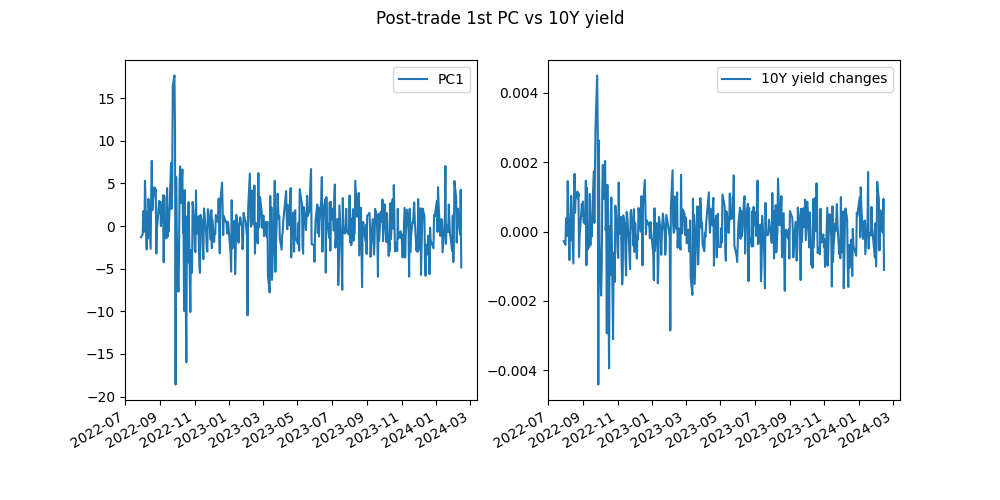

In [22]:
# plot the first PC with 10y yield
print(f"the correlation between 1st PC (post-trade) and 10Y yield changes is: {np.corrcoef(PC1, -df_changes.loc[post_trade_dates,10])[0][1]}")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(post_trade_dates, -PC1, label='PC1')
plt.legend()
plt.subplot(1,2,2)
plt.plot(post_trade_dates, df_changes.loc[post_trade_dates,10], label='10Y yield changes')
# make the x-axis date less
plt.gcf().autofmt_xdate()
plt.legend()
# a super title
plt.suptitle('Post-trade 1st PC vs 10Y yield')


the correlation between 2nd PC (post-trade) and 5-10 spread is: 0.8675118405412499
the correlation between 2nd PC (post-trade) and 5s10s20s butterfly is: 0.6351565758641149
the correlation between 2nd PC (post-trade) and PnL: 0.10276466242734103


Text(0.5, 0.98, 'Post-trade 2nd PC vs 5-10 spread and 5s10s20s butterfly')

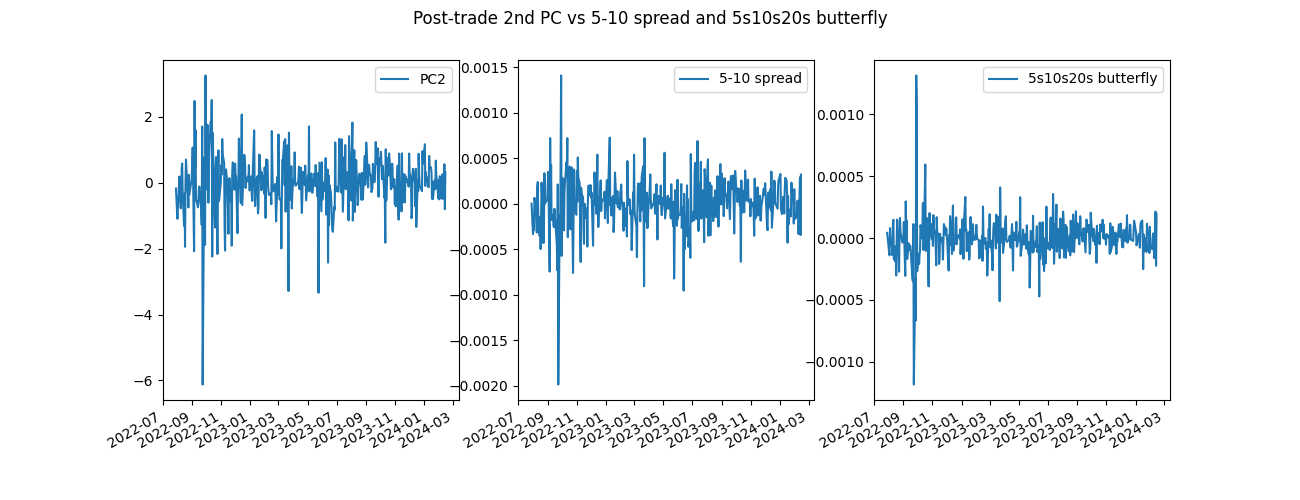

In [23]:
# plot the 2nd PC with 5-10 spread and 2s5s10s butterfly
PC2 = post_trade_scales.dot(eigenvectors[:,1])
print(f"the correlation between 2nd PC (post-trade) and 5-10 spread is: {np.corrcoef(PC2, post_trade_spread)[0][1]}")
print(f"the correlation between 2nd PC (post-trade) and 5s10s20s butterfly is: {np.corrcoef(PC2, post_trade_butterfly)[0][1]}")
print(f"the correlation between 2nd PC (post-trade) and PnL: {np.corrcoef(pnl_series, PC2)[0][1]}")
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.plot(post_trade_dates,PC2, label='PC2')
plt.legend()
plt.subplot(1,3,2)
plt.plot(post_trade_dates,post_trade_spread, label='5-10 spread')
plt.legend()
plt.subplot(1,3,3)
plt.plot(post_trade_dates,post_trade_butterfly, label='5s10s20s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()

# a super title
plt.suptitle('Post-trade 2nd PC vs 5-10 spread and 5s10s20s butterfly')

correlation between PC3 and 5s10s20s butterfly: -0.04211740674069739
correlation between PC3 and 5-10 spread: -0.2301359446547837
correlation between PC3 and pnl: -0.5346446677035495


Text(0.5, 0.98, 'Post-trade 3rd PC vs 5s10s20s butterfly')

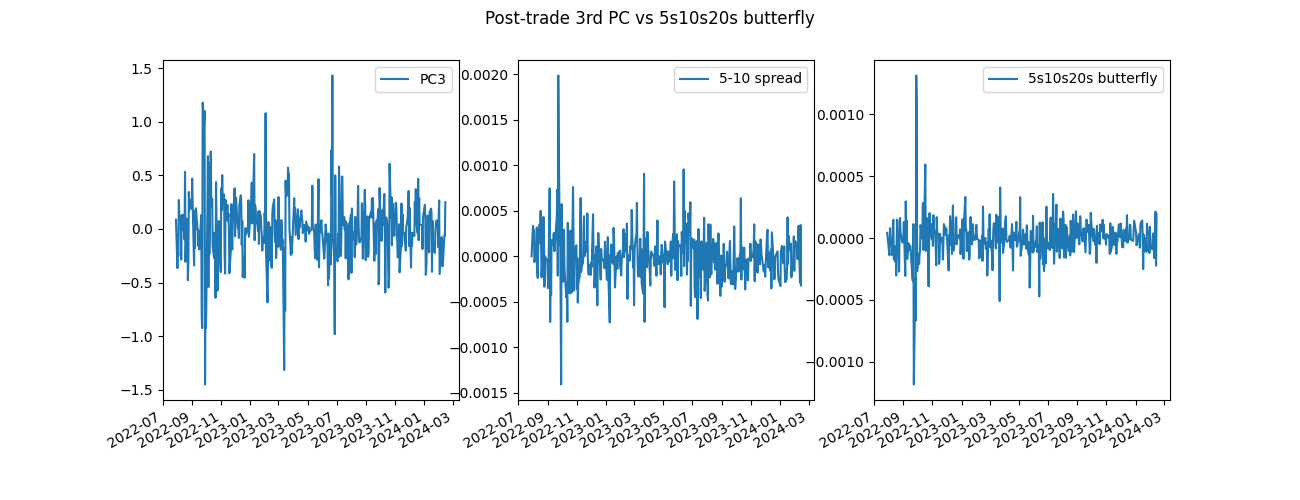

In [24]:
# 3rd PC
PC3 = post_trade_scales.dot(eigenvectors[:,2])
print(f"correlation between PC3 and 5s10s20s butterfly: {np.corrcoef(PC3, post_trade_butterfly)[0][1]}")
print(f"correlation between PC3 and 5-10 spread: {np.corrcoef(PC3, -post_trade_spread)[0][1]}")
print(f"correlation between PC3 and pnl: {np.corrcoef(PC3, pnl_series)[0][1]}")
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.plot(post_trade_dates,PC3, label='PC3')
plt.gcf().autofmt_xdate()
plt.legend()
plt.subplot(1,3,2)
plt.plot(post_trade_dates,-post_trade_spread, label='5-10 spread')
plt.gcf().autofmt_xdate()
plt.legend()
plt.subplot(1,3,3)
plt.plot(post_trade_dates,post_trade_butterfly, label='5s10s20s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()
# a super title
plt.suptitle('Post-trade 3rd PC vs 5s10s20s butterfly')